# Practical 4: Clustering

## Import 

In [133]:
import sklearn.datasets as data
from sklearn.datasets import make_blobs
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import random 
import numpy as np
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings("ignore")
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as hierarchy
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors

## Part 2: Getting Started

Text(0, 0.5, 'X_0')

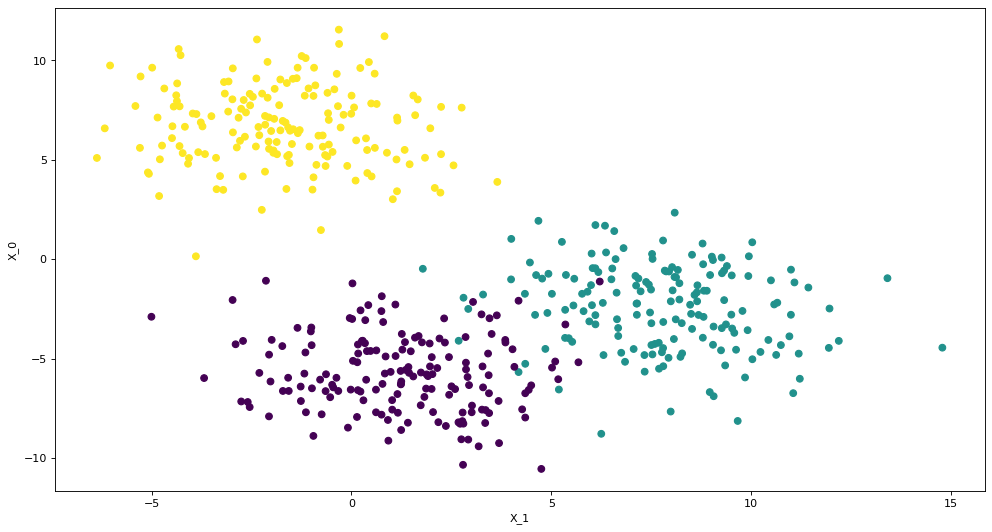

In [157]:
random.seed(6)
# Create synthetic data for the clustering
X, clusters = make_blobs(n_samples =500 , n_features=3, cluster_std =2.0)


# Plot the synthetic data
figure(figsize=(15, 8), dpi=80)
# Plot the original data 
plt.scatter(X[:, 0], X[:, 1], c=clusters.astype(float))
# Label axes
plt.xlabel( 'X_1', fontsize=10 )
plt.ylabel( 'X_0', fontsize=10 )


## Part 3: Write K-Means Yourself

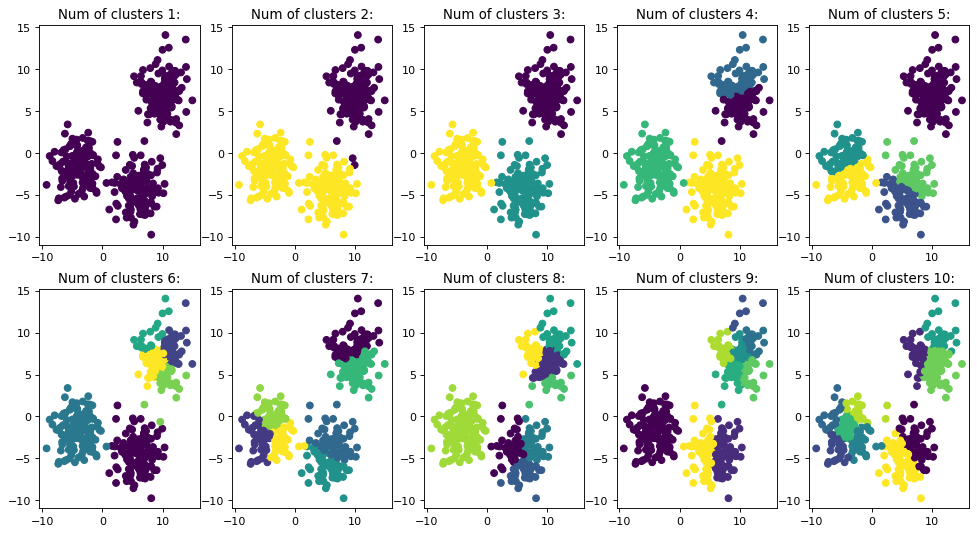

In [13]:
##################################################################################
#################### Define Helper Functions #####################################
##################################################################################

def calculate_distance(feature_vector: np.array , center_vector: np.array)->float:
    """
    Calculate Euclidean distance between sample point and given cluster center.
    
    :param feature_vector: The vector of the training observation of type `np.array`.
    :param center_vector: The vector of the cluster center of type `np.array`.
    :return distance: The euclidean distance between the 2 vectors.
    """
    distance = np.sqrt(sum((feature_vector - center_vector)**2))
    return distance
    
    

def find_closest_cluster(feature_vector: np.array, center_vectors: np.array)->int:
    """
    Find the closest cluster center for a given feature vector.
    
    :param feature_vector: The vector of the training observation of type `np.array`.
    :param center_vector: The vectors of the cluster centers of type `np.array`. Each row corresponds to a different 
    cluster center.
    :return cluster: The index of the closest cluster.
    """
    min_dist = np.inf # The minimum distance of the input sample point from any cluster center.
    min_dist_index = None # The index of the closest cluster center.
    nrow, ncol = center_vectors.shape
    for i in range(0, nrow):
        current_center = center_vectors[i]  # Numpy array of current cluster center.
        current_distance = calculate_distance(feature_vector, current_center)  # Calculate Euclidean distance.
        if current_distance < min_dist:
            min_dist = current_distance
            min_dist_index = i + 1
        else:
            pass
    
    cluster = min_dist_index  # Return closest cluster for this sample point.
    return cluster 


########################################################################
######################### END of Helper Functions ######################
########################################################################

#random.seed(150)
# For the cases where we have empty clusters we just need to select an existing point as the center for the empty
# cluster.

def custom_k_means(X_train: np.array, num_of_centers: int)->list:
    """ Perform K means clustering.
    
    :param X_train: The dataset to be clustered of type `np.array`.
    :param num_of_centers: The number of clusters for the k means clustering.
    :return result: This is going to be a list where the first element is 
    the assigned cluster labels for each observation in the X_train dataset (of type `list`)
    the second element is a np.array with the cluster centers..
    """
    result = []  # List with the results.
    available_cluster_labels = list(range(1,num_of_centers+1))
    # Find min and maximum value for each of our predictors 
    # At this point we assume that we have only 2 predictors 
    # If we want to take into consideration more than 2 variables we need to modify this part.
    nrow, ncol = X_train.shape
    x0_min, x0_max = X_train[:, 0].min(), X_train[:, 0].max()
    x1_min, x1_max = X_train[:, 1].min(), X_train[:, 1].max()
    clusters = np.empty((num_of_centers, ncol))
    for i in range(0,num_of_centers): # Create a list of possible centers 
        clusters[i] = [random.uniform(x0_min, x0_max+1), random.uniform(x1_min, x1_max+1)]
    
    # Repeat until convergence -> cluster mean vectors do not change.
    # We know that our algorithm will converge.

    assigned_class = []
    while True:
        assigned_class = []
        for i in range(0,nrow):
            assigned_class.append(find_closest_cluster(X_train[i], clusters))  # Assign each observation to closest cluster.
            
        # Check if there are any empty clusters.
        # In that case just assign a random point into that cluster.
        Empty_clusters = set(available_cluster_labels).difference(set(assigned_class))
        
        # Assign a point randomly to an every one of the empty clusters.
        k = 0
        for clust in Empty_clusters:  # I do not really like this part but for now it works.
            #random_obs = random.randint(0, len(assigned_class)-1)  # Pick an observation at random to change it.
            assigned_class[k] = clust
            k = k + 1
            

        # Update the cluster centers 
        update_center_vectors = []
        for index in range(num_of_centers):
            # For each cluster calculate new cluster centers 
            selected_rows = list(map(lambda num: num == index+1, assigned_class))
            selected_rows = X_train[selected_rows,:]
            if selected_rows.size == 0:
                print('Cluster {} is empty'.format(index+1))
                assigned_class = None
                break
            updated_center = selected_rows.mean(axis=0)  # Calculate new cluster centers 
            updated_center = np.array(updated_center)
            update_center_vectors.append(list(updated_center))
        
        update_center_vectors = np.array(update_center_vectors)
    
        # Finally check if we have convergence 
        # Otherwise Update the centers and repeat the process.
        if  np.array_equal(clusters, update_center_vectors):  
            result.append(clusters)
            result.append(assigned_class)
            #print('Cluster Centers are: ', clusters)
            #print('Assigned clusters are: ', assigned_class)
            return result
        else: # If the algorithm has not converged update the centers 
            clusters = update_center_vectors
            
            continue


def calc_WC(X_train: np.array, cluster_centers: np.array, cluster_indexes:list) ->float:
    """
    Calculate Within Cluster score.
    
    :param X_train: The dataset with the training observations of type `np.array`.
    :param cluster_centers: The produced cluster centers from the custom K-means of type `np.array`.
    :param cluster_indexes: The class labels for each line of the dataset of type `list`.
    :return score: The within cluster score of type `float`.
    """
    score = 0
    nrow, ncol = X_train.shape
    for i in range(nrow):  # For each observation calculate the distance from its cluster center.
        score = score + calculate_distance(X_train[i], cluster_centers[cluster_indexes[i]-1])**2
    return score
    

def calc_BC(cluster_centers: np.array):
    """ Calculate the between clusters score. 
    
    :param cluster_centers: The produced cluster centers from the custom K-means of type `np.array`.
    :return score: The between clusters score.
    """
    score = 0
    n_row, n_col = cluster_centers.shape
    for i in range(n_row):
        for j in range(i+1, n_row):
            score = score + calculate_distance(cluster_centers[i], cluster_centers[j])**2    
    return score   
            
    
def calc_over_score(WC:float, BC:float)->float:
    """ Calculate overall score of the clustering.
    
    
    :param score: Overal score of the clustering.
    """
    return BC/WC
    

#################################################################            
################ RUN K-means clustering #########################
#################################################################

# Run k=means for different number of clusters 
# and compare results 

WC_values = []
BC_values = []
overall_score = []
k = list(range(1,11))

figure(figsize=(15, 8), dpi=80)
for num in k:  # Itterate over all possible values of K 
    numb_of_clusters = num            
    result = custom_k_means(X, numb_of_clusters)
    k_means = result[1] # Class labels
    centers = result[0] # Class centers

    # Plot clustering results
    #figure(figsize=(15, 8), dpi=80)
    plt.subplot( 2, 5, num)
    # Plot the original data 
    plt.scatter(X[:, 0], X[:, 1], c=k_means)
    # Label axes
    plt.title('Num of clusters {}:'.format(num))
    WC_values.append(calc_WC(X, centers, k_means))
    BC_values.append(calc_BC(centers))
    overall_score.append(calc_over_score(calc_WC(X, centers, k_means), calc_BC(centers) ))

## Plot WC and BC scores

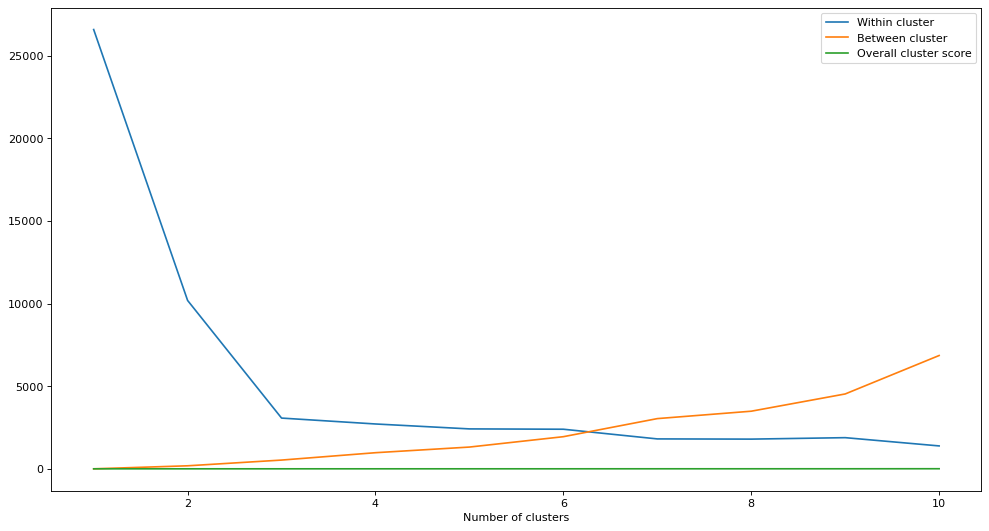

In [14]:
figure(figsize=(15, 8), dpi=80)
plt.plot(k, WC_values, label = "Within cluster")
plt.plot(k, BC_values, label = "Between cluster")
plt.plot(k, overall_score, label = "Overall cluster score")
plt.xlabel('Number of clusters')
plt.legend()

## Run Evaluation Results 30 times for Each value of K

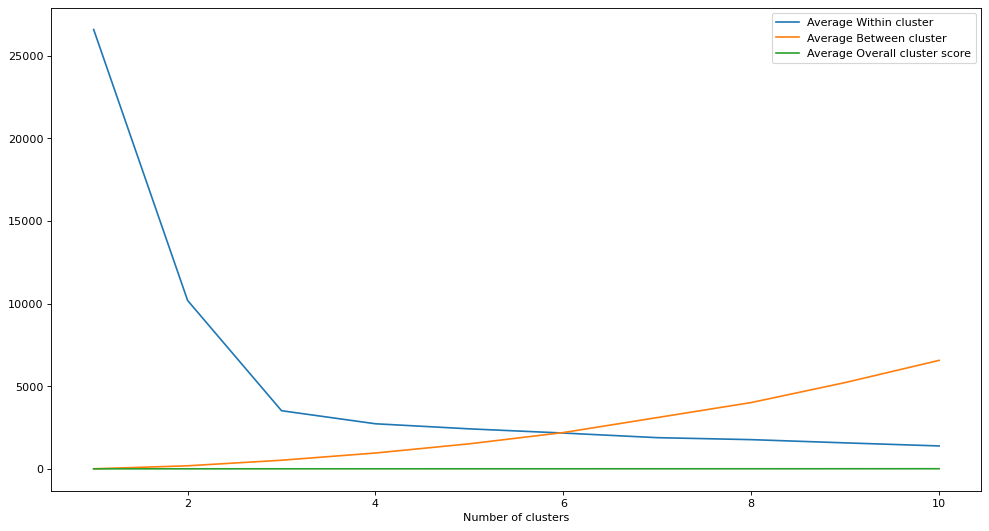

In [15]:
WC_values = [0]*len(k)
BC_values = [0]*len(k)
overall_score = [0]*len(k)
k = list(range(1,11))
itterations = 30

for i in range(0,itterations):
    for num in k:  # Itterate over all possible values of K 
        numb_of_clusters = num            
        result = custom_k_means(X, numb_of_clusters)
        k_means = result[1] # Class labels
        centers = result[0] # Class centers
        
        WC_values[num-1]= WC_values[num-1] + calc_WC(X, centers, k_means)
        BC_values[num-1]= BC_values[num-1] + calc_BC(centers)
        overall_score[num-1]= overall_score[num-1] + calc_over_score(calc_WC(X, centers, k_means), calc_BC(centers) )
        
WC_values     = [y/itterations for y in WC_values] # Take the average Within Cluster score among all itterations 
BC_values     = [y/itterations for y in BC_values] # Take the average Between Cluster score among all itterations 
overall_score = [y/itterations for y in overall_score] # Take the average Between Cluster score among all itterations 

figure(figsize=(15, 8), dpi=80)
plt.plot(k, WC_values, label = "Average Within cluster")
plt.plot(k, BC_values, label = "Average Between cluster")
plt.plot(k, overall_score, label = "Average Overall cluster score")
plt.xlabel('Number of clusters')
plt.legend()

## Part 4: Use K-Means from scikit-learn

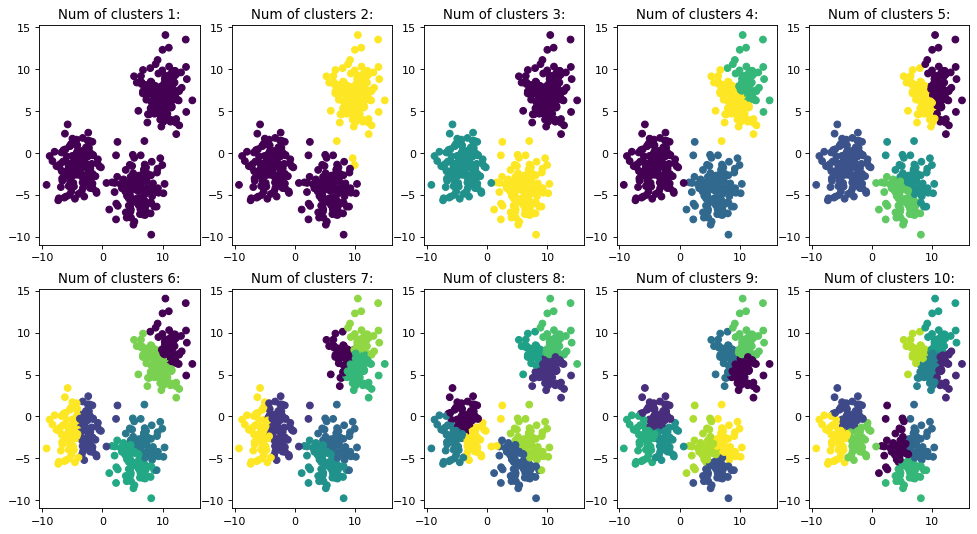

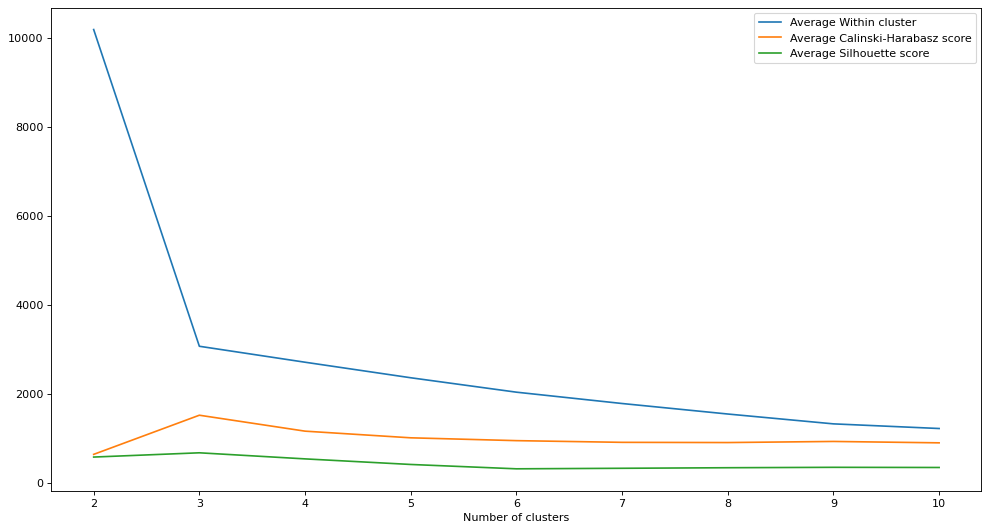

In [17]:
## Run Built-k means for different values of K in plot the results of clustering
k = list(range(1,11))

figure(figsize=(15, 8), dpi=80)
for num in k:  # Itterate over all possible values of K            
    km = cluster.KMeans(n_clusters=num)
    km.fit(X)
    # Plot clustering results
    #figure(figsize=(15, 8), dpi=80)
    plt.subplot( 2, 5, num)
    # Plot the original data 
    plt.scatter(X[:, 0], X[:, 1], c=km.labels_)
    # Label axes
    plt.title('Num of clusters {}:'.format(num))


# Calculate the average performance of k-means clustering for different values for the number of clusters.
k = list(range(2,11))
WC_values = [0]*len(k)
SC_values = [0]*len(k)
CH_values = [0]*len(k)

itterations = 30

for i in range(0,itterations):
    for num in k:  # Itterate over all possible values of K         
        km = cluster.KMeans(n_clusters=num)
        km.fit(X)
        # compute the clusters:
        WC_values[num-2]=  WC_values[num-2] + km.inertia_
        SC_values[num-2]=  SC_values[num-2] + metrics.silhouette_score(X, km.labels_, metric='euclidean')
        CH_values[num-2]=  CH_values[num-2] + metrics.calinski_harabasz_score(X, km.labels_)


        
WC_values     = [y/itterations for y in WC_values] # Take the average Within Cluster score among all itterations 
SC_values     = [(y/itterations)*1000 for y in SC_values] # Take the average and scale in order to plot the in the same plot
CH_values     = [y/itterations for y in CH_values] # Take the average     

figure(figsize=(15, 8), dpi=80)
plt.plot(k, WC_values, label = "Average Within cluster")
plt.plot(k, CH_values, label = "Average Calinski-Harabasz score")
plt.plot(k, SC_values, label = "Average Silhouette score")
plt.xlabel('Number of clusters')
plt.legend()

## Part 5: Write Agglomerative Clustering using scikit-learn

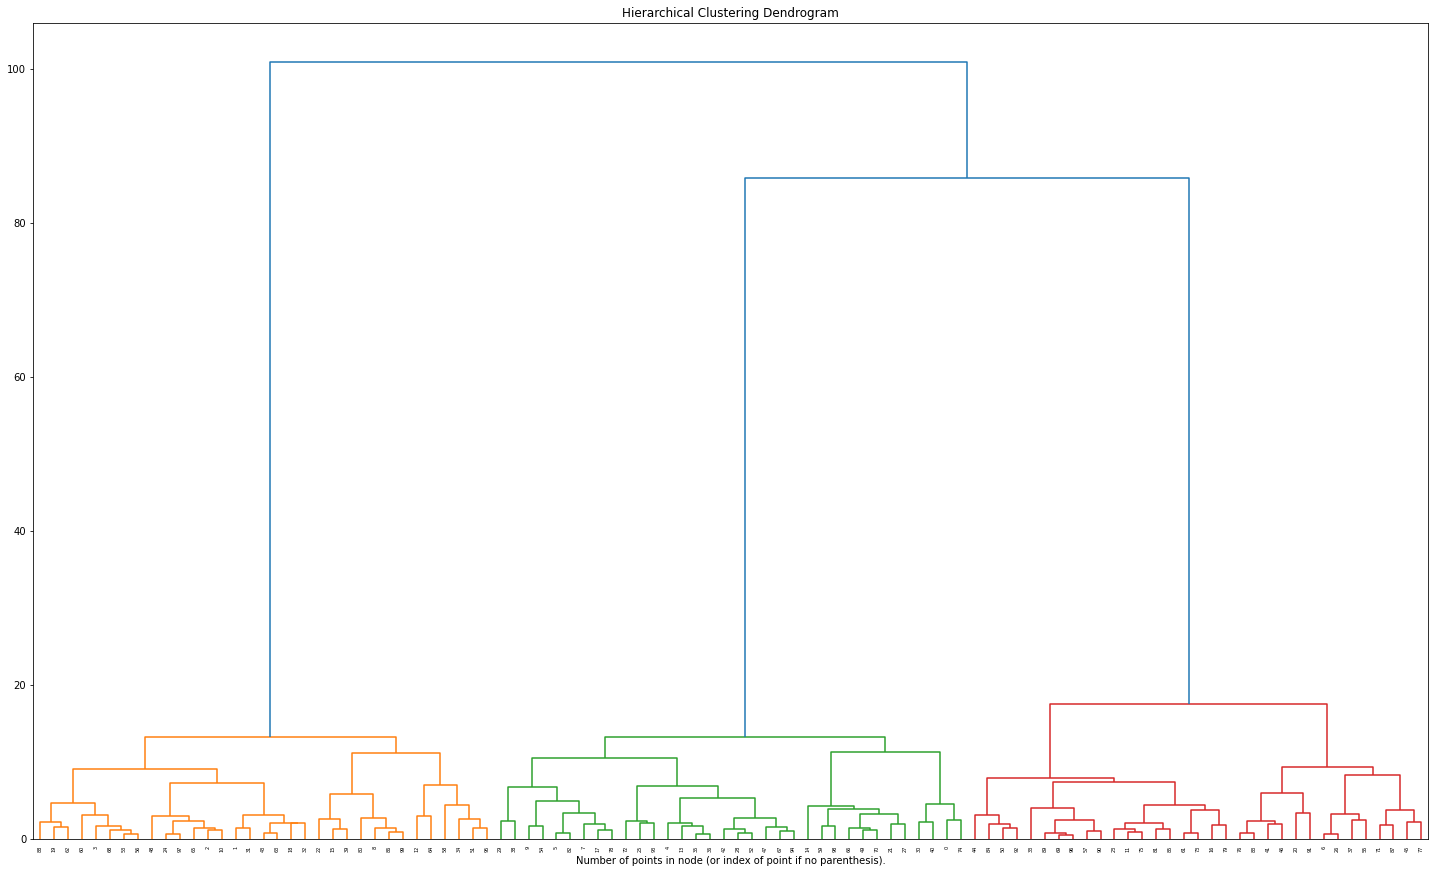

In [93]:
# initialise the agglomerative clustering object
#ac = cluster.AgglomerativeClustering(n_clusters=K, linkage='average' , affinity='euclidean' )
# compute the clusters:
#ac.fit(X)
#Z = ac.children_

linkage_m = None

def plot_dendrogram(model, **kwargs):
    global linkage_m
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    linkage_m = linkage_matrix
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
hc =  cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hc = model.fit(X)
fig, axes = plt.subplots(1, 1, figsize=(25, 15))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


## Alternative Solution

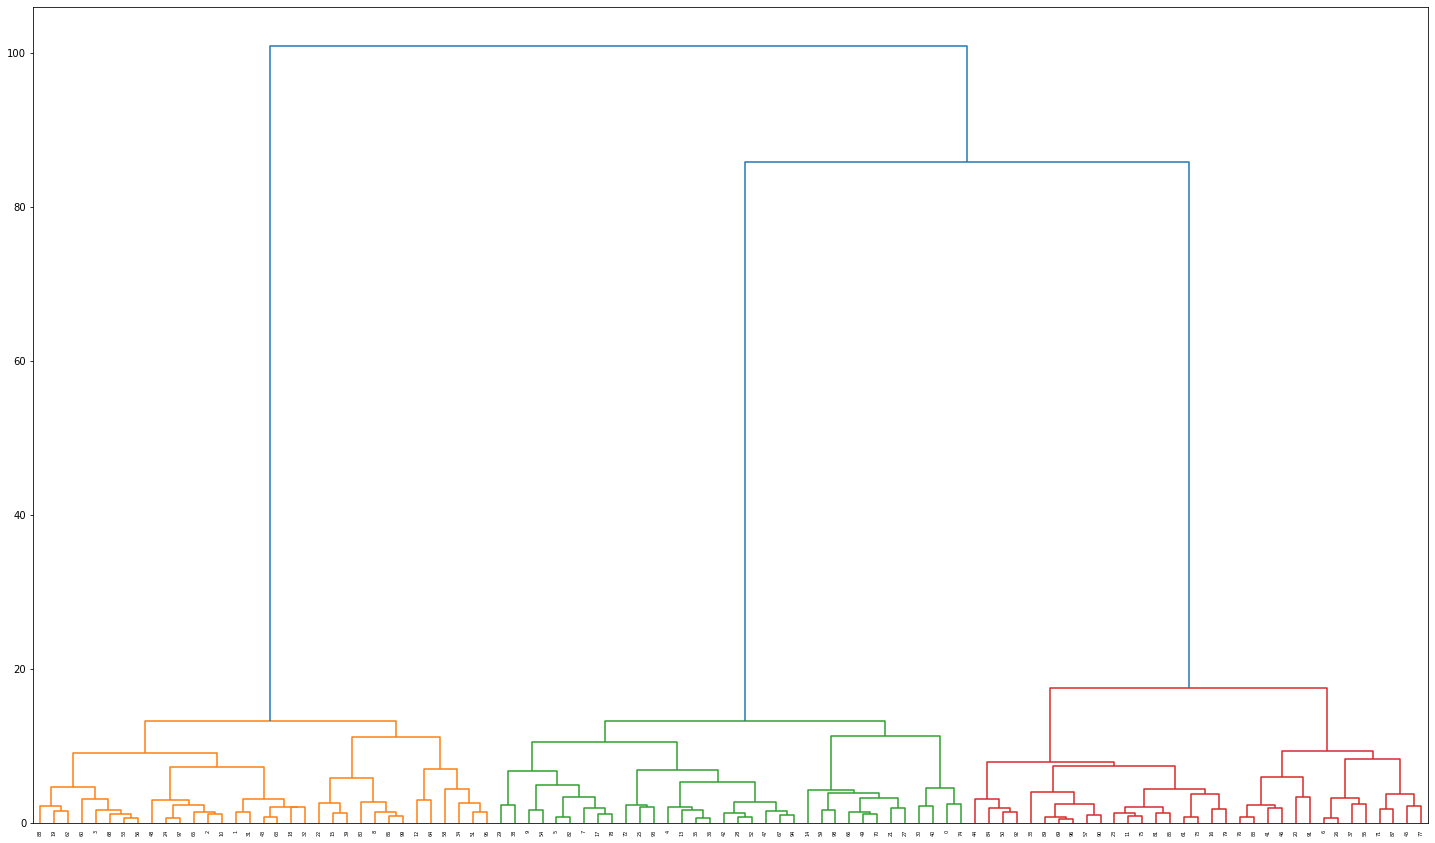

In [105]:

# setting distance_threshold=0 ensures we compute the full tree.
hc =  cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hc = model.fit(X)


#figure(figsize=(8, 6), dpi=80)
plt.figure(figsize=(25, 15))
# initialise data structure for scipy dendrogram printing function
Z=np.empty([len(hc.children_),4],dtype=float)

#cluster_distances = np.arange(hc.children_.shape[0])
cluster_distances = linkage_m[:,2]

cluster_sizes=np.arange(2,hc.children_.shape[0]+2)
for i in range(len(hc.children_)):
    Z[i][0]=hc.children_[i][0]
    Z[i][1]=hc.children_[i][1]
    Z[i][2]=cluster_distances[i]
    Z[i][3]=cluster_sizes[i]
#plotdendrogram
hierarchy.dendrogram(Z)
plt.show()


## Calculate measures for different number of clusters

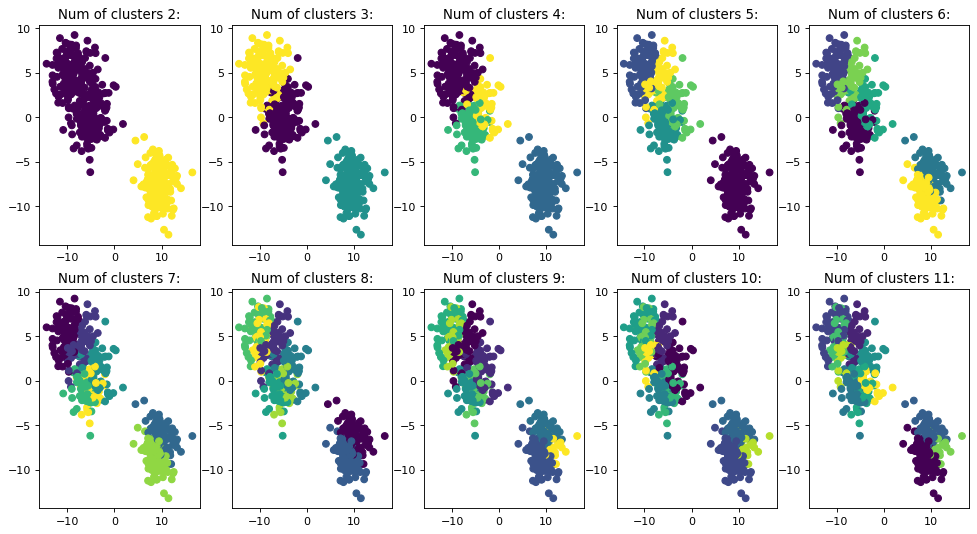

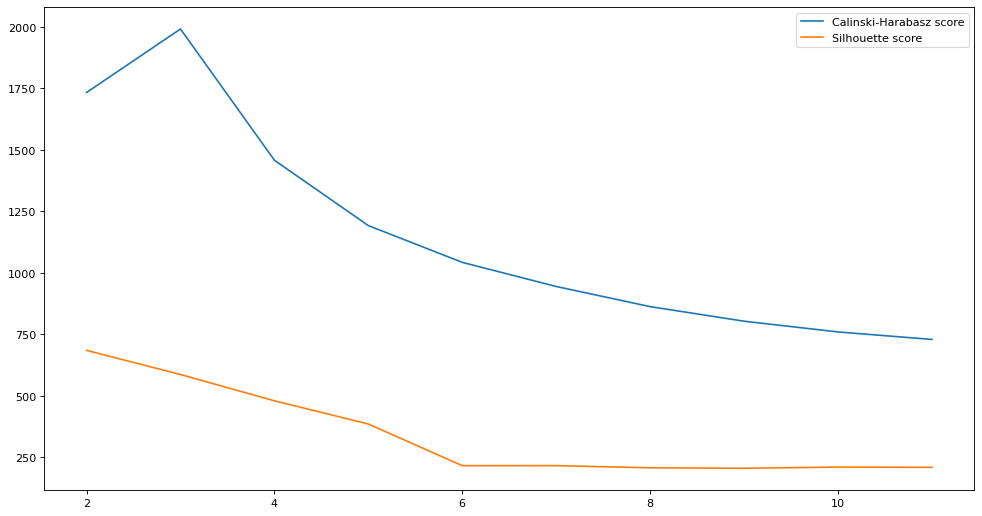

In [147]:
num_clusters = list(range(2,12))
sil_score = []
cal_score = []

figure(figsize=(15, 8), dpi=80)
for num in num_clusters:
    clustering = cluster.AgglomerativeClustering(n_clusters=num).fit(X)
    clustering.labels_
    sil_score.append(silhouette_score(X, clustering.labels_))
    cal_score.append(calinski_harabasz_score(X, clustering.labels_))
    plt.subplot( 2, 5, num-1)
    # Plot the original data 
    plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_)
    # Label axes
    plt.title('Num of clusters {}:'.format(num))

    
sil_score = [y*1000 for y in sil_score] # Take the average and scale in order to plot the in the same plot
    
    
figure(figsize=(15, 8), dpi=80)
plt.plot(num_clusters, cal_score, label = "Calinski-Harabasz score")
plt.plot(num_clusters, sil_score, label = "Silhouette score")
plt.legend()

## Part 6 - DBSCAN 


Silhouette_score:  -0.19277125659200678
Calinski_harabasz_score:  33.80465375877484


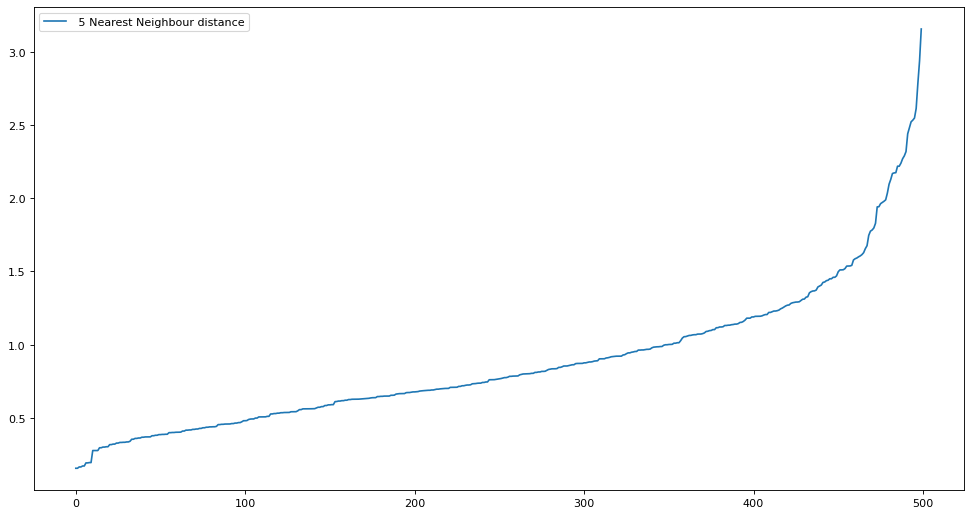

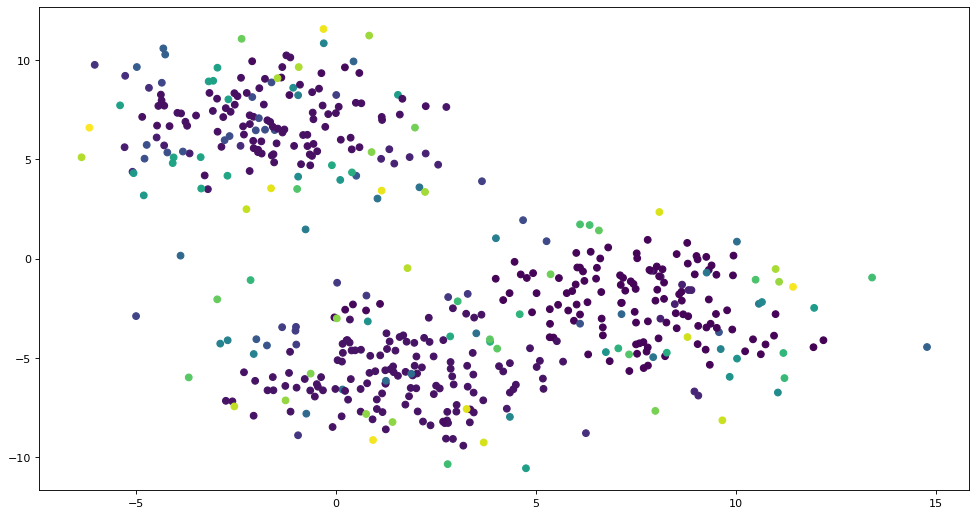

In [159]:
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

Nmin = 5
Eps_value = 1.2

# initialise the DBSCAN clustering object
db = cluster.DBSCAN(eps=Eps_value , min_samples=1)

# compute the clusters
db.fit(X)

# initialise the nearest neighbours_object

nn = NearestNeighbors(n_neighbors=Nmin, metric='euclidean' )

# fit the data to find the nearest_neighbours to every instance
nn.fit(X)

# return the K nearest neighbours (K=n_neighbors argument )
dist, ind = nn.kneighbors( X, n_neighbors=Nmin)
distance_values = sorted(dist[:,1])

# Plot the distances to find best value for Eps
figure(figsize=(15, 8), dpi=80)
plt.plot(distance_values, label = " {} Nearest Neighbour distance".format(Nmin))
plt.legend()

# Plot the clusters for the chosen values of the hyperparameters
figure(figsize=(15, 8), dpi=80)
plt.scatter(X[:, 0], X[:, 1], c=db.labels_)



print()
print('Silhouette_score: ', silhouette_score(X, db.labels_))
print('Calinski_harabasz_score: ', calinski_harabasz_score(X, db.labels_))


In [152]:
calinski_harabasz_score(X, db.labels_)

87.48722414668045